# $\mathrm{MEK}$ (Methyl Ethyl Ketone)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3C(O)C2H5" 
nice_name = "Methyl Ethyl Ketone"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 207.0, 208.0, 209.0  …  334.0, 335.0, 336.0, 337.0, 338.0, 339.0, 340.0, 341.0, 342.0, 343.0], [1.35e-20, 5.8e-21, 3.93e-21, 2.45e-21, 1.77e-21, 1.57e-21, 1.48e-21, 1.42e-21, 1.38e-21, 1.37e-21  …  2.2e-22, 1.6e-22, 1.3e-22, 9.0e-23, 7.0e-23, 5.0e-23, 3.0e-23, 2.0e-23, 2.0e-23, 1.0e-23], [242.0, 253.0, 273.0, 296.0, 320.0, 296.0, 323.0, 261.0, 298.0, 298.0  …  298.0, 298.0, 298.0, 296.0, 300.0, 298.0, 298.0, 296.0, 294.0, 298.0], [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  23, 23, 23, 23, 23, 23, 23, 23, 23, 23], "K", "Organics (carbonyls)", "CH3C(O)C2H5", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

2656


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,284.39,165.037,293.36,375.975,0,Float64
2,σ,3.99269e-19,1.00234e-24,1.0005e-20,1.03e-17,0,Float64
3,T,296.013,294.0,296.0,300.0,0,Float64
4,source_id,16.3483,4,19.0,23,0,Int64


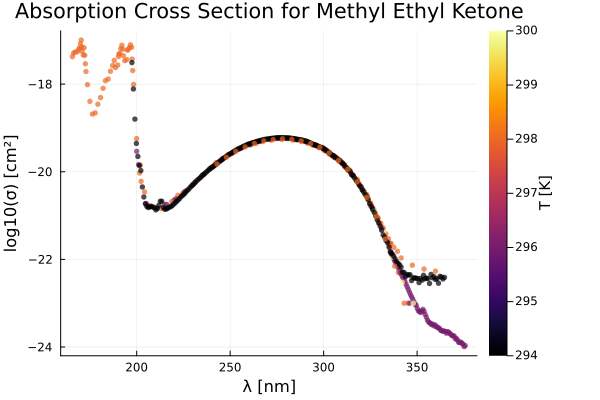

In [8]:
nskip = 5

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


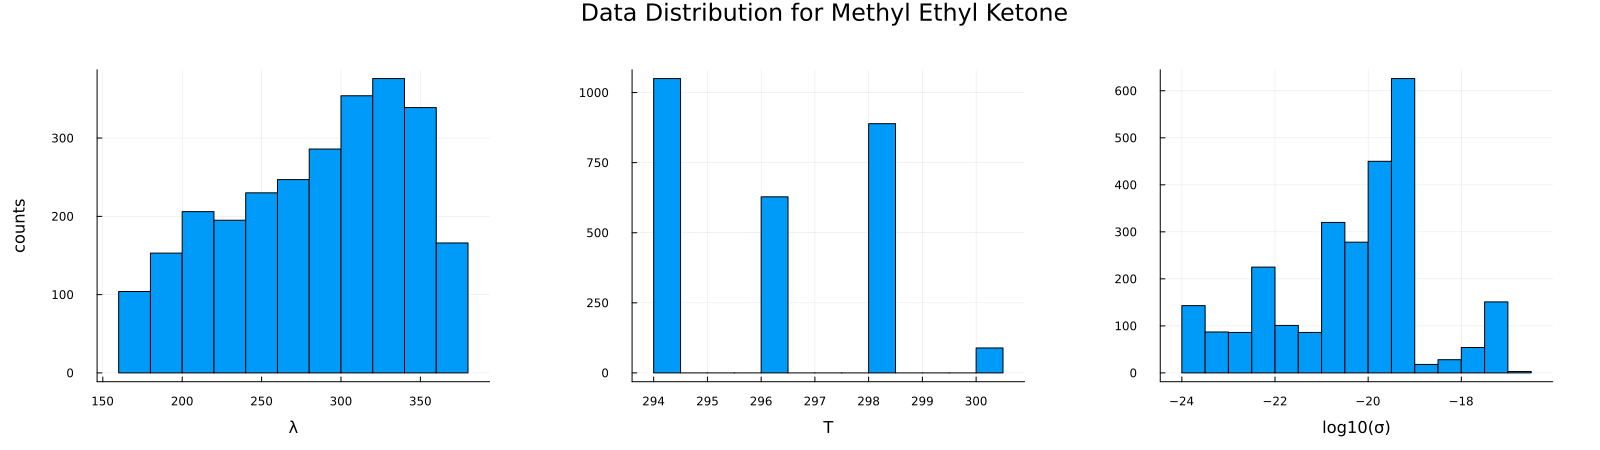

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,196.96,4.892e-18,294.0
2,197.12,4.635e-18,294.0
3,197.28,4.224e-18,294.0
4,197.44,3.102e-18,294.0
5,197.6,2.089e-18,294.0
6,197.76,1.584e-18,294.0
7,197.92,1.254e-18,294.0
8,198.08,9.995e-19,294.0
9,198.24,7.734e-19,294.0


In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

2439


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(1995, 3)


165.037

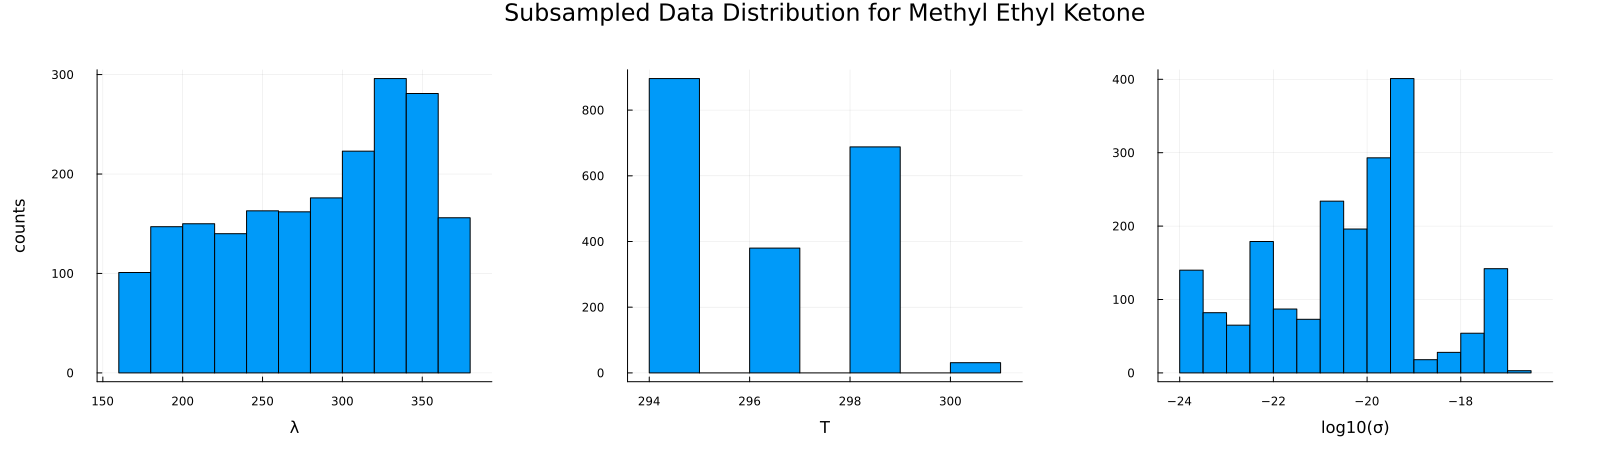

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

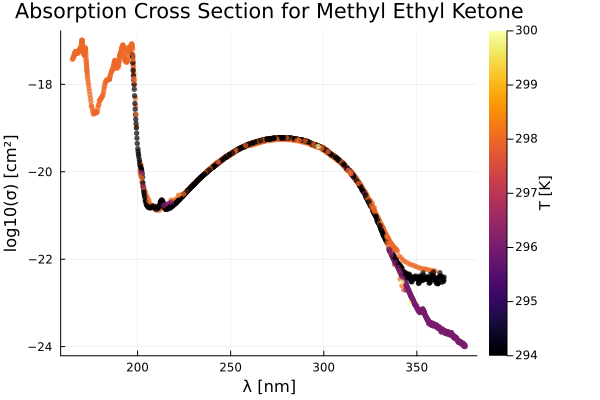

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [17]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1795


In [18]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

200-element Vector{Float64}:
 -18.000217201545865
 -21.968591535748377
 -19.298086788787657
 -19.436044535004186
 -20.39902710431325
 -17.108016769148033
 -19.801617869991706
 -18.393296258666325
 -19.425043224235495
 -19.424235019463282
 -23.505129132685067
 -19.42033070644528
 -20.795880017344075
   ⋮
 -19.31794522292619
 -19.428524096318057
 -20.820161071976813
 -21.30189945437661
 -23.401457888811134
 -19.883724412419454
 -23.872260429053892
 -23.948164724526077
 -21.869666231504993
 -21.097561943801335
 -20.237321436272563
 -20.069050968832478

In [33]:
# compute length scales
κ = 1
ℓ_λ = 5.0 # std(Xtrain.λ)/κ
ℓ_T = 0.1 # std(Xtrain.T)/κ

# compute variance parameters
SNR = 100
σf² = 5.0 # var(ytrain)
σₙ² = 0.001 # (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))

function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [34]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.6094379094538682, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(1.6094379094538682, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-2.3025852420056685, exp, 1.4901161193847656e-8)), 
  σ² = 0.001, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [35]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -1.214315e+03     1.879455e+03
 * time: 0.0001499652862548828
     1    -1.766222e+03     5.592816e+02
 * time: 5.181229114532471
     2    -1.862403e+03     9.018806e+02
 * time: 7.082187175750732
     3    -2.070082e+03     6.314890e+02
 * time: 8.946774959564209
     4    -2.123334e+03     2.220009e+02
 * time: 10.889135122299194
     5    -2.141934e+03     2.107927e+02
 * time: 12.720335006713867
     6    -2.170139e+03     2.300626e+02
 * time: 14.829092025756836
     7    -2.183025e+03     1.850413e+01
 * time: 16.686336994171143
     8    -2.183259e+03     7.442231e+00
 * time: 19.058951139450073
     9    -2.183294e+03     2.431932e+00
 * time: 20.93092107772827
    10    -2.183293e+03     1.777459e+00
 * time: 50.9498450756073
    11    -2.183291e+03     3.701163e-02
 * time: 52.14370799064636
    12    -2.183291e+03     1.392625e-02
 * time: 84.04948210716248
    13    -2.183291e+03     1.291103e-01
 * time: 93.03190898895264

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @121 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @897 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [36]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.6663837219643116, 1.354131001021461, -2.302514137032301, -6.451069494402466],
 minimum = -2183.314095930435,
 iterations = 25,
 converged = true,)

In [37]:
fp = fitted_params(mach)

(θ_best = [:σf² => 39.110216418830184, :ℓ_λ => 3.8733935335849674, :ℓ_T => 0.10000711074907905],
 σ² = 0.0015788476138778884,)

In [38]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


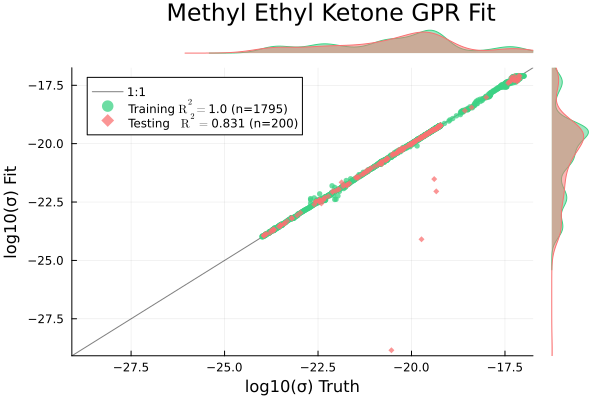

In [39]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


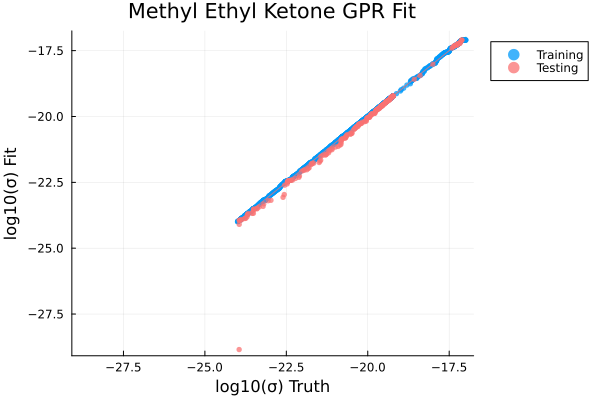

In [40]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


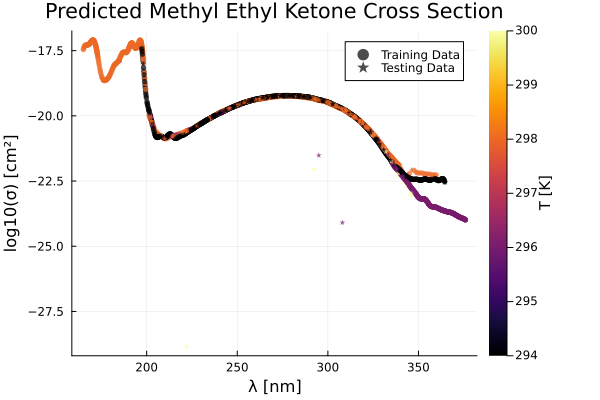

In [41]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

194.249
375.975


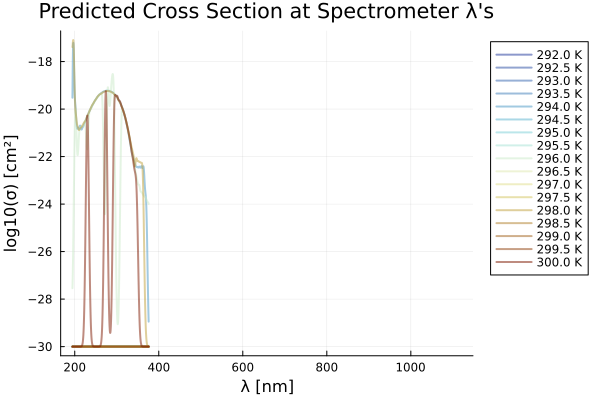

In [42]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

function predict_logσ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = predict_mean(mach, Xout)
    
    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    res[idxs] .= NaN 
    return res
end



p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

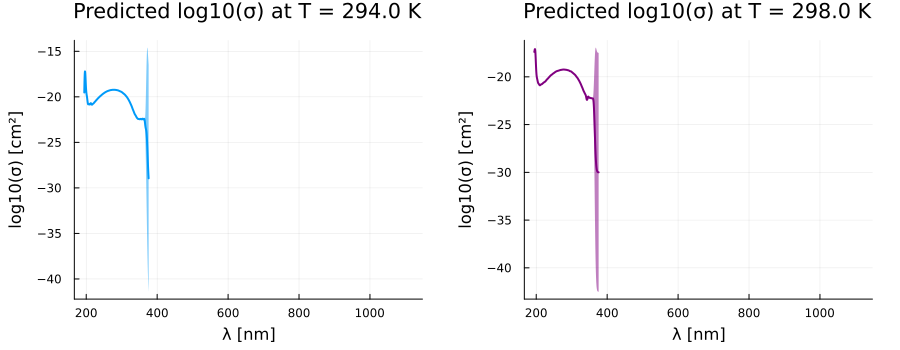

In [44]:
function predict_logσ_wΔ(T, λs, mach, λ_bounds)
    λ_lb, λ_ub = λ_bounds
    
    Xout = copy(λs)
    Tout = T
    Xout[!, :T] = [Tout for _ ∈ 1:nrow(λs)]
    res = MLJ.predict(mach, Xout)

    logσ = mean.(res)
    Δlogσ = std.(res)

    idxs = [idx for idx ∈ 1:nrow(Xout) if (Xout.λ[idx] ≤ λ_lb) || (λ_ub ≤ Xout.λ[idx])]
    logσ[idxs] .= NaN 
    Δlogσ[idxs] .= NaN 
    return logσ, Δlogσ
    #return res
end

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 